## Homework 4
*For any questions or concerns please email your instructor at `smanna@scu.edu`*
### Due - 03/06/2020 - 11:59p - 50 points

**Name:** `<Jeffrey Lin>`

**Email** `<jlin7@scu.edu>`

**Objectives:** The aim of this homework is to warm you up with `logistic regression` concept. You have to implement univariate linear regression by using `scikit-learn`.

**Problem Statement:** Across the nation, judges, probation and parole officers are increasingly using algorithms to assess a criminal defendant’s likelihood of becoming a recidivist – a term used to describe criminals who re-offend. There are dozens of these risk assessment algorithms in use. Many states have built their own assessments, and several academics have written tools. There are also two leading nationwide tools offered by commercial vendors.

We set out to assess one of the commercial tools made by Northpointe, Inc. to discover the underlying accuracy of their recidivism algorithm and to test whether the algorithm was biased against certain groups. 


**Submission Instructions:** 
* Please download `hw4.ipynb` and `compas-scores-two-years-violent.csv` files and insert cells in the `hw4.ipynb` to complete your homework and submit the same file to Camino under `Homework` $\rightarrow$ `hw4`. Please feel free to use the `w8-LogisticRegression.ipynb` as a reference to work on this homework.

**Honor Code:** You are expected to complete the homework on your own. Solutions might exist elsewhere, but you are not allowed to copy them. 

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from pandas.plotting import scatter_matrix
from sklearn import metrics
%matplotlib inline

In [170]:
fname ='compas-scores-two-years-violent.csv'

# it's upto you whether you would use the following variables or not
decile_col = 'decile_score'
score_col = 'score_text'

In [171]:
# read the file in dataframe
cv = pd.read_csv(fname)

In [172]:
# list the features of your dataset (aka columns)
cv.columns.tolist()
#cv.columns

['id',
 'name',
 'first',
 'last',
 'compas_screening_date',
 'sex',
 'dob',
 'age',
 'age_cat',
 'race',
 'juv_fel_count',
 'decile_score',
 'juv_misd_count',
 'juv_other_count',
 'priors_count',
 'days_b_screening_arrest',
 'c_jail_in',
 'c_jail_out',
 'c_case_number',
 'c_offense_date',
 'c_arrest_date',
 'c_days_from_compas',
 'c_charge_degree',
 'c_charge_desc',
 'is_recid',
 'r_case_number',
 'r_charge_degree',
 'r_days_from_arrest',
 'r_offense_date',
 'r_charge_desc',
 'r_jail_in',
 'r_jail_out',
 'violent_recid',
 'is_violent_recid',
 'vr_case_number',
 'vr_charge_degree',
 'vr_offense_date',
 'vr_charge_desc',
 'type_of_assessment',
 'decile_score.1',
 'score_text',
 'screening_date',
 'v_type_of_assessment',
 'v_decile_score',
 'v_score_text',
 'v_screening_date',
 'in_custody',
 'out_custody',
 'priors_count.1',
 'start',
 'end',
 'event',
 'two_year_recid',
 'two_year_recid.1']

Following ProPublica, we filter out certain rows which are missing data. As they put it:

- If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
- We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
- In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed
- We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [173]:
# Data filtering is implemented for you
cv = cv[
    (cv.days_b_screening_arrest <= 30) &  
    (cv.days_b_screening_arrest >= -30) &  
    (cv.is_recid != -1) &
    (cv.c_charge_degree != 'O') &
    (cv[score_col] != 'N/A')
]

cv.reset_index(inplace=True, drop=True) # renumber the rows from 0 again


#### Question 1 (10 points): Exploring the data

In [174]:
cv.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,two_year_recid.1
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,1
2,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,...,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0,0
3,9,steven stewart,steven,stewart,2013-08-30,Male,1973-02-25,43,25 - 45,Other,...,Low,2013-08-30,2014-05-22,2014-06-03,3,0,265,0,0,0
4,10,elizabeth thieme,elizabeth,thieme,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,...,Low,2014-03-16,2014-03-15,2014-03-18,0,2,747,0,0,0


In [175]:
# Print the nature of crime each individual has committed
cv[['name','c_charge_desc']]

,name,c_charge_desc
0,miguel hernandez,Aggravated Assault w/Firearm
1,kevon dixon,Felony Battery w/Prior Convict
2,marsha miles,Battery
3,steven stewart,arrest case no charge
4,elizabeth thieme,Battery
5,benjamin franc,"Poss 3,4 MDMA (Ecstasy)"
6,kortney coleman,Battery
7,jarrod turbe,"Poss3,4 Methylenedioxymethcath"
8,mario hernandez,Battery
9,darrious davis,Grand Theft in the 3rd Degree


In [176]:
# How many violent crimes have been committed?
v = cv[cv['is_violent_recid'] == True].shape[0]
print 'Number of violent crimes: ', v

Number of violent crimes:  692


### which is the most prevalent age group for violent crimes?
cv.age_cat[cv['is_violent_recid'] == True].value_counts()

In [177]:
# How many women are involved in violent crimes.
#cv.sex[cv['is_violent_recid'] == '1'].value_counts().sort_index()
f = cv[(cv['is_violent_recid'] == True) & (cv['sex']=='Female')].shape[0]
print'Women involved in violent crimes: ', f


Women involved in violent crimes:  82


In [178]:
# Print the decile scores for each race
cv.race[cv['decile_score']].value_counts()

African-American    1540
Caucasian           1219
Other               1057
Hispanic             199
Name: race, dtype: int64

In [179]:
# Show recidivism by race (make sure you consider all races)
r = cv[cv['is_recid'] == True]['race'].value_counts()
r

African-American    516
Caucasian           226
Hispanic             43
Other                41
Asian                 5
Native American       2
Name: race, dtype: int64

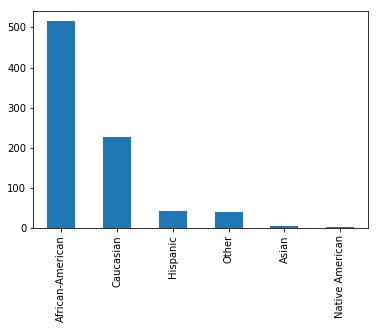

In [180]:
# Plot a bar chart which has probability of recidivism by decile and race( every race)
r.plot(kind = 'bar')

In [181]:
# Create COMPAS recidivism confusion matrix
# Explain your observation
cv['guessed_recid'] = cv[score_col] != 'Low'
cv['actual_recid'] = cv.two_year_recid == 1
cm = pd.crosstab(cv.actual_recid, cv.guessed_recid)
cm

guessed_recid,False,True
actual_recid,,
False,2345,1023
True,221,431


Use logistic regression to try to build our own predictor, just from the information we have.

`Age`
`Sex`
`Felony or Misdemeanor charge (c_charge_degree)`
`Number of prior arrests (c_priors_count)`

Now you will try building your predictor **both with and without race** and illustrate the difference in results.

#### Question 2 (5 points): Logistic Regression using race as an additional feature

In [182]:
# Logistic Regression using race
# you can use the same x for training and testing
features = pd.concat(
    [pd.get_dummies(cv.age_cat, prefix='age'),
     pd.get_dummies(cv.sex, prefix='sex'),
     pd.get_dummies(cv.c_charge_degree, prefix='degree'), # felony or misdemeanor charge ('f' or 'm')
     pd.get_dummies(cv.race, prefix='race'),
     cv.priors_count],
    axis=1)

target = cv.two_year_recid

x = features.values
y = target.values
lr = LogisticRegression()
lr.fit(x,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [183]:
# show the confusion matrix using race
y_pred = lr.predict(x)
guessed = pd.Series(y_pred) == 1

actual = cv.two_year_recid == 1

cm = pd.crosstab(guessed, actual, rownames = ['guessed'], colnames = ['actual'])
cm

actual,False,True
guessed,,
False,3321,598
True,47,54


In [184]:
# compute accuracy, precision, FPR, FNR
def print_ppv_fpv(cm):
    # the indices here are [col][row] or [actual][guessed]
    TN = cm[0][0]   
    TP = cm[1][1]
    FN = cm[1][0]
    FP = cm[0][1]
    print('Accuracy: ', ( TN+TP)/(TN+TP+FN+FP))
    print('PPV: ', TP / (TP + FP))
    print('FPR: ', FP / (FP + TN))
    print('FNR: ', FN / (FN + TP))
    print()

print_ppv_fpv(cm)

('Accuracy: ', 0)
('PPV: ', 0)
('FPR: ', 0)
('FNR: ', 0)
()


#### Question 3 (5 points): Logistic Regression without race as an additional feature

In [190]:
# Logistic Regression without race
# you can use the same x for training and testing
features = pd.concat(
    [pd.get_dummies(cv.age_cat, prefix='age'),
     pd.get_dummies(cv.sex, prefix='sex'),
     pd.get_dummies(cv.c_charge_degree, prefix='degree'), # felony or misdemeanor charge ('f' or 'm')
     cv.priors_count],
    axis=1)

target = cv.two_year_recid

x = features.values
y = target.values
lr = LogisticRegression()
lr.fit(x,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [191]:
# show the confusion matrix without race
y_pred = lr.predict(x)
guessed = pd.Series(y_pred) == 1

actual = cv.two_year_recid == 1

cm = pd.crosstab(guessed, actual, rownames = ['guessed'], colnames = ['actual'])
cm

actual,False,True
guessed,,
False,3317,591
True,51,61


In [187]:
# compute accuracy, precision, FPR, FNR

In [188]:
print_ppv_fpv(cm)

('Accuracy: ', 0)
('PPV: ', 0)
('FPR: ', 0)
('FNR: ', 0)
()


### Optional (EC-3 pts)

Using the [Framework for Ethical Decision Making](https://www.scu.edu/media/ethics-center/ethical-decision-making/A-Framework-for-Ethical-Decision-Making.pdf), how would you reconsider analyzing this dataset so that it would give a fair judgment.

In [189]:
# # Ethical take away from the findings